# Data Loading

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bike-sharing-demand/sampleSubmission.csv
/kaggle/input/bike-sharing-demand/train.csv
/kaggle/input/bike-sharing-demand/test.csv


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

file_path = '/kaggle/input/bike-sharing-demand/train.csv'
bike_df = pd.read_csv(file_path)
print(bike_df.shape)
bike_df.head(3)

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32


In [3]:
bike_test = pd.read_csv('/kaggle/input/bike-sharing-demand/test.csv')

In [4]:
for column in bike_df.columns:
    if column not in bike_test.columns:
        print(column)

casual
registered
count


In [5]:
bike_df.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count'],
      dtype='object')

## Column Analysis

* Target = count
* count = casual + registered
* train: 'datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count'
* test: 'datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed'

In [6]:
bike_df.shape[0], bike_test.shape[0], bike_test.shape[0] / bike_df.shape[0]

(10886, 6493, 0.5964541613081021)

Train : Test ~= 3 : 5

## Data Type Adjustment

In [7]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [8]:
bike_df['datetime'] = bike_df['datetime'].apply(pd.to_datetime)

In [9]:
# datetime 타입에서 년, 월, 일, 시간 추출
bike_df['year'] = bike_df.datetime.apply(lambda x : x.year)
bike_df['month'] = bike_df.datetime.apply(lambda x : x.month)
bike_df['day'] = bike_df.datetime.apply(lambda x : x.day)
bike_df['hour'] = bike_df.datetime.apply(lambda x: x.hour)
bike_df['dow'] = bike_df.datetime.apply(lambda x: x.dayofweek)

drop_columns = ['datetime','casual','registered'] # count = casual + registered
bike_df.drop(drop_columns, axis=1,inplace=True)
bike_df.head(3)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour,dow
0,1,0,0,1,9.84,14.395,81,0.0,16,2011,1,1,0,5
1,1,0,0,1,9.02,13.635,80,0.0,40,2011,1,1,1,5
2,1,0,0,1,9.02,13.635,80,0.0,32,2011,1,1,2,5


## Column Type Classification

* Category: season, holiday, weather, workingday, year, month, day, hour
* Numerical Variables
    * Continuous: temp, atemp, windspeed
    * Discrete: humidity, count

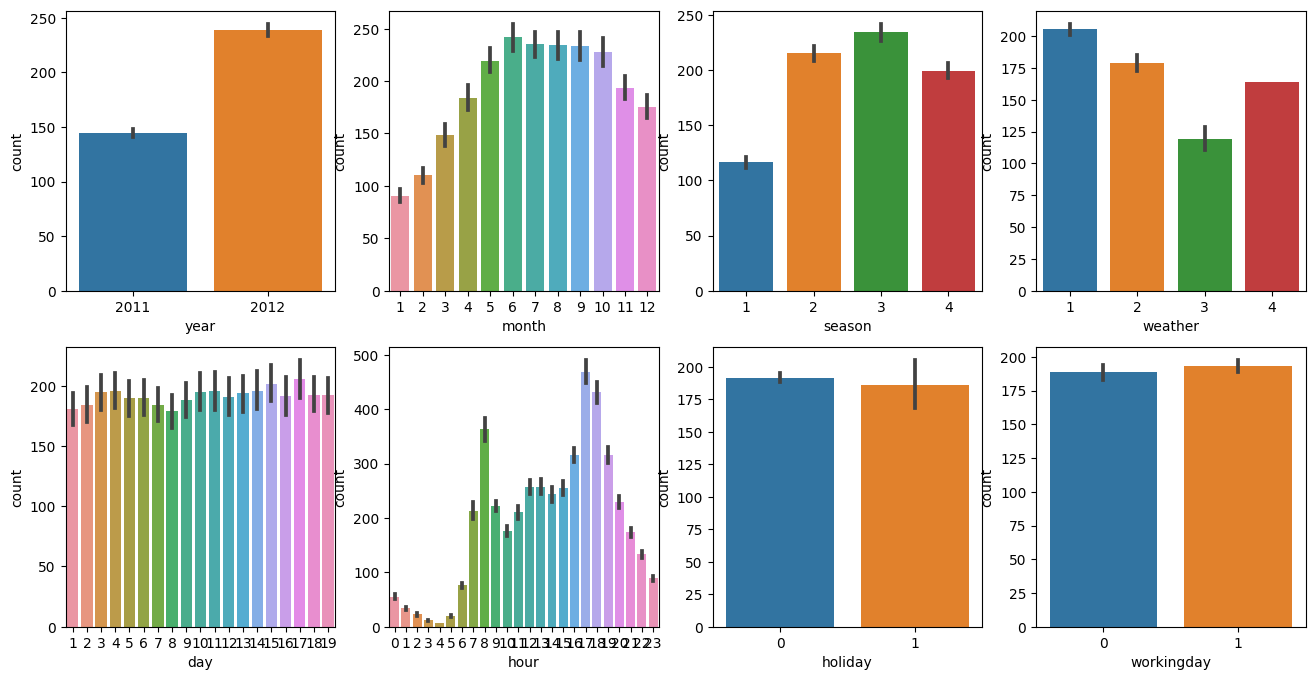

In [10]:
fig, axs = plt.subplots(figsize=(16, 8), ncols=4, nrows=2)
cat_features = ['year', 'month','season','weather','day', 'hour', 'holiday','workingday']
# cat_features에 있는 모든 칼럼별로 개별 칼럼값에 따른 count의 합을 barplot으로 시각화
for i, feature in enumerate(cat_features):
    row = int(i/4)
    col = i%4
    # 시본의 barplot을 이용해 칼럼값에 따른 count의 합을 표현
    sns.barplot(x=feature, y='count', data=bike_df, ax=axs[row][col])

<Axes: xlabel='windspeed', ylabel='count'>

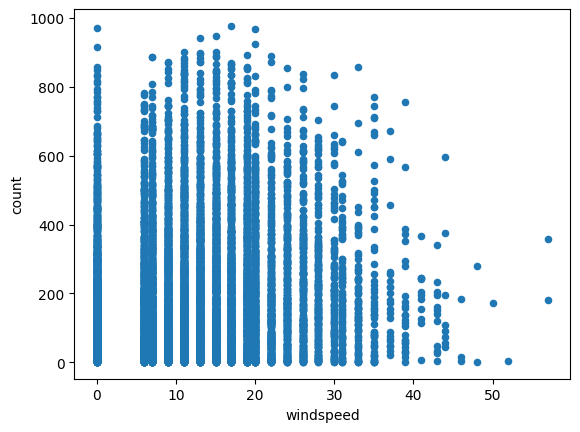

In [11]:
bike_df.plot.scatter(x='windspeed',y='count')

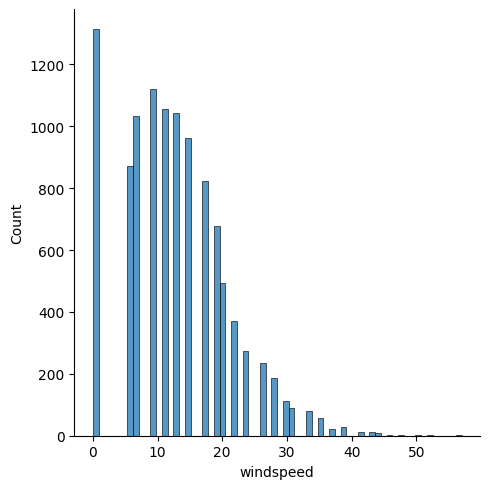

In [12]:
sns.displot(bike_df['windspeed'])

# Function Definition

## rmsle

log1p() 를 이용하여 RMSLE 계산한 값을 출력

In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

## rmse

MSE를 입력받아 RMSE 계산한 값을 출력

In [14]:
def rmse(y,pred):
    return np.sqrt(mean_squared_error(y,pred))

## evaluate_regr

MSE, RMSE, RMSLE 를 각각 계산하여 print함수를 이용해 한 줄로 결과값 출력

In [15]:
def evaluate_regr(y,pred):
    rmsle_val = rmsle(y,pred)
    rmse_val = rmse(y,pred)
    # MAE 는 scikit learn의 mean_absolute_error() 로 계산
    mae_val = mean_absolute_error(y,pred)
    print('RMSLE: {0:.3f}, RMSE: {1:.3F}, MAE: {2:.3F}'.format(rmsle_val, rmse_val, mae_val))

## get_top_error_data

예측값과 실제값을 입력받아서 그 중 차이가 가장 큰 것을 내림차순으로 출력

In [16]:
def get_top_error_data(y_test, pred, n_tops = 5):
    # DataFrame에 컬럼들로 실제 대여횟수(count)와 예측 값을 서로 비교 할 수 있도록 생성. 
    result_df = pd.DataFrame(y_test.values, columns=['real_count'])
    result_df['predicted_count']= np.round(pred)
    result_df['diff'] = np.abs(result_df['real_count'] - result_df['predicted_count'])
    # 예측값과 실제값이 가장 큰 데이터 순으로 출력. 
    print(result_df.sort_values('diff', ascending=False)[:n_tops])

# Modeling & Evaluation

## Linear Regression

In [17]:
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.linear_model import LinearRegression , Ridge , Lasso

y_target = bike_df['count']
drop_col = ['count','day','temp'] # Target, Split Standard, temp ~= atepm but less descriptive
X_features = bike_df.drop(drop_col,axis=1,inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

evaluate_regr(y_test ,pred)

RMSLE: 1.165, RMSE: 140.817, MAE: 105.871


In [18]:
get_top_error_data(y_test,pred,n_tops=5)

      real_count  predicted_count   diff
1618         890            319.0  571.0
966          884            324.0  560.0
3151         798            246.0  552.0
412          745            195.0  550.0
2314         766            222.0  544.0


<Axes: >

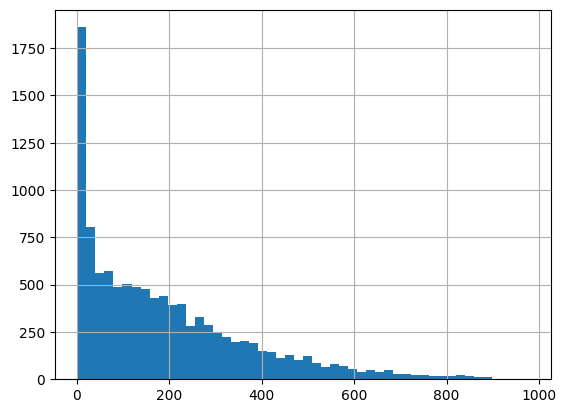

In [19]:
y_target.hist(bins = 50)

## y_target: Log Scaling

<Axes: >

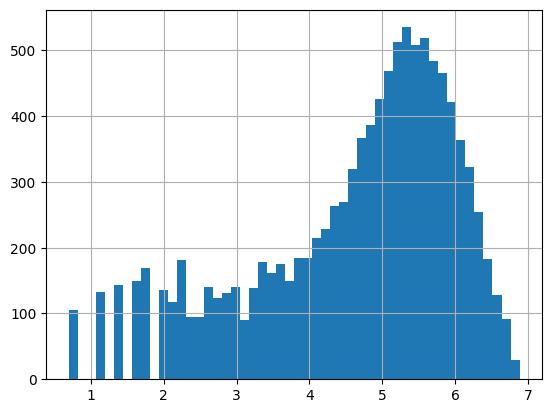

In [20]:
y_log_transform = np.log1p(y_target)
y_log_transform.hist(bins = 50)

Scaled Data Set Split & Linear Regression Modeling Evaluation

## Reevaluation

In [21]:
# 타깃 칼럼인 count 값을 log1p로 로그 변환
y_target_log = np.log1p(y_target)

# 로그 변환된 y_target_log를 반영하여 학습/테스트 데이터 셋 분할
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target_log, test_size=0.3, random_state=0)
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

# 테스트 데이터 셋의 Target 값은 Log 변환되었으므로 다시 expm1를 이용하여 원래 scale로 변환
y_test_exp = np.expm1(y_test)

# 예측 값 역시 Log 변환된 타깃 기반으로 학습되어 예측되었으므로 다시 exmpl으로 scale변환
pred_exp = np.expm1(pred)

evaluate_regr(y_test_exp ,pred_exp)

RMSLE: 1.016, RMSE: 162.671, MAE: 109.222


* Result: Even worse than before scaling

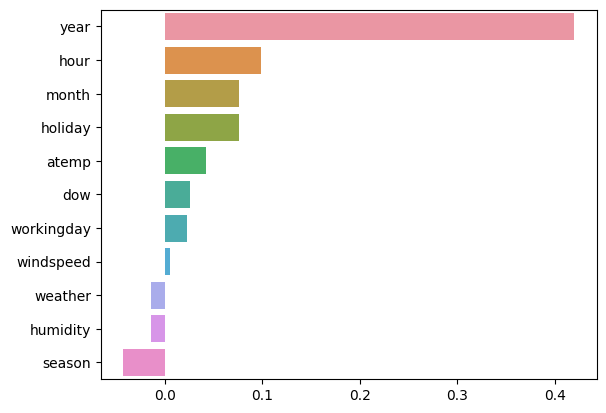

In [22]:
coef = pd.Series(lr_reg.coef_, index=X_features.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)
plt.savefig('log_transform.png', format='png', dpi=300, bbox_inches='tight')

### Coefficiant index Ananlysis
* Important Columns: Year
* Unrelevant Columns: windspeed

## X_category_features Ont-hot Encoding

In [23]:
# 'year', month', 'day', hour'등의 피처들을 One Hot Encoding
X_features_ohe = pd.get_dummies(X_features, 
                                columns = ['year', 'month', 'dow','holiday','workingday','season','weather'], #hour 노미미
                                drop_first=True
                               )

### Re-Evaluation

In [24]:
# 원-핫 인코딩이 적용된 feature 데이터 세트 기반으로 학습/예측 데이터 분할. 
X_train, X_test, y_train, y_test = train_test_split(X_features_ohe, y_target_log,
                                                    test_size=0.3, random_state=0)

# 모델과 학습/테스트 데이터 셋을 입력하면 성능 평가 수치를 반환
def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    if is_expm1 :
        y_test = np.expm1(y_test)
        pred = np.expm1(pred)
    print('###',model.__class__.__name__,'###')
    evaluate_regr(y_test, pred)
# end of function get_model_predict    

# model 별로 평가 수행
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=10)
lasso_reg = Lasso(alpha=0.01)

for model in [lr_reg, ridge_reg, lasso_reg]:
    get_model_predict(model,X_train, X_test, y_train, y_test,is_expm1=True)

### LinearRegression ###
RMSLE: 1.002, RMSE: 159.278, MAE: 106.616
### Ridge ###
RMSLE: 1.002, RMSE: 159.293, MAE: 106.627
### Lasso ###
RMSLE: 1.008, RMSE: 160.719, MAE: 107.664


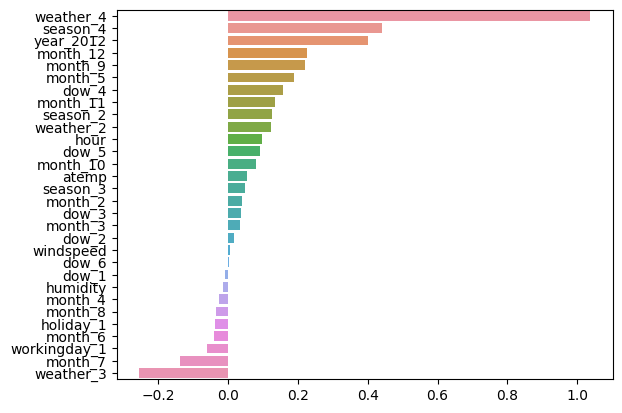

In [25]:
coef = pd.Series(lr_reg.coef_ , index=X_features_ohe.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values , y=coef_sort.index)
plt.savefig('one-hotencoded.png', format='png', dpi=300, bbox_inches='tight')

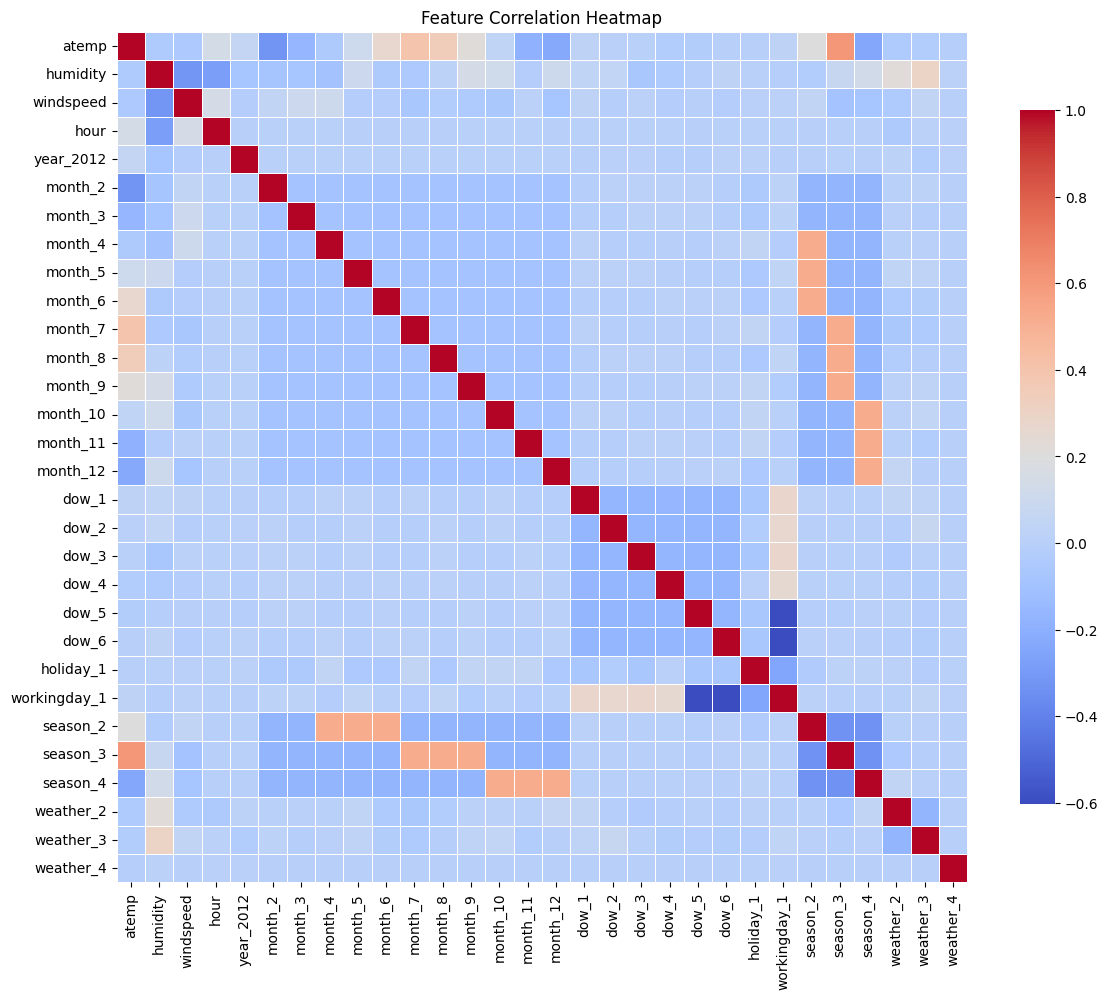

In [26]:
corr_matrix = X_features_ohe.corr()

# 2. 히트맵 시각화
plt.figure(figsize=(12, 10))  # 크기 조정
sns.heatmap(corr_matrix, cmap='coolwarm', square=True,
            cbar_kws={"shrink": 0.8}, linewidths=0.5)

plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.savefig('correlation_heatmap.png', dpi=300)
plt.show()

## Regression Tree

In [27]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

params = {'n_estimators': 500, 
          'max_depth': 5, 
          'random_state': 0, 
          'min_samples_leaf' : 10, 
          'learning_rate': 0.1, 
          'subsample': 0.7, 
          'loss': 'squared_error'
         } #Ranker's Hyperparameter
Best_Parameters = {'subsample': 0.9, 'verbose' : -1, 'reg_lambda': 0.0, 'reg_alpha': 0.0, 'num_leaves': 20, 'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.07, 'colsample_bytree': 0.8}
# 랜덤 포레스트, GBM, XGBoost, LightGBM model 별로 평가 수행
rf_reg = RandomForestRegressor(n_estimators=500)
gbm_reg = GradientBoostingRegressor(**params)
xgb_reg = XGBRegressor(n_estimators=500)
lgbm_reg = LGBMRegressor(**Best_Parameters)

for model in [rf_reg, gbm_reg, xgb_reg, lgbm_reg]:
    # XGBoost의 경우 DataFrame이 입력 될 경우 버전에 따라 오류 발생 가능. ndarray로 변환.
    get_model_predict(model,X_train.values, X_test.values, y_train.values, y_test.values,is_expm1=True)

### RandomForestRegressor ###
RMSLE: 0.319, RMSE: 45.403, MAE: 27.381
### GradientBoostingRegressor ###
RMSLE: 0.290, RMSE: 40.891, MAE: 24.735
### XGBRegressor ###
RMSLE: 0.304, RMSE: 43.836, MAE: 25.765
### LGBMRegressor ###
RMSLE: 0.287, RMSE: 41.932, MAE: 25.438


* Result: A lot better than Liear Regression, and my

### Hyperparameter Tunning

In [28]:
from sklearn.metrics import mean_squared_log_error, make_scorer
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import early_stopping

# 각 모델에 대한 파라미터 그리드
param_grids = {
        'num_leaves': [20, 35, 50],
        'learning_rate': [0.03, 0.05, 0.07],
        'max_depth': [4, 6, 8],
        'reg_alpha': [0.0, 0.1, 0.5],
        'reg_lambda': [0.0, 0.1, 0.5],
        'subsample': [0.7, 0.8, 0.9],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'n_estimators': [500, 800, 1000]
    }

model = LGBMRegressor(verbose = -1)
rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grids,
        n_iter=50, #기존10
        scoring=rmsle_scorer,
        cv=3,
        verbose=1,
        random_state=42,
        n_jobs=-1
    )
search.fit(X_train, y_train, feature_name = list(X_train.columns))
best_model = search.best_estimator_

print("Best Parameters:", search.best_params_)
get_model_predict(best_model, X_train.values, X_test.values, y_train.values, y_test.values, is_expm1=True)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'subsample': 0.9, 'reg_lambda': 0.0, 'reg_alpha': 0.0, 'num_leaves': 20, 'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.07, 'colsample_bytree': 0.8}
### LGBMRegressor ###
RMSLE: 0.287, RMSE: 41.932, MAE: 25.438


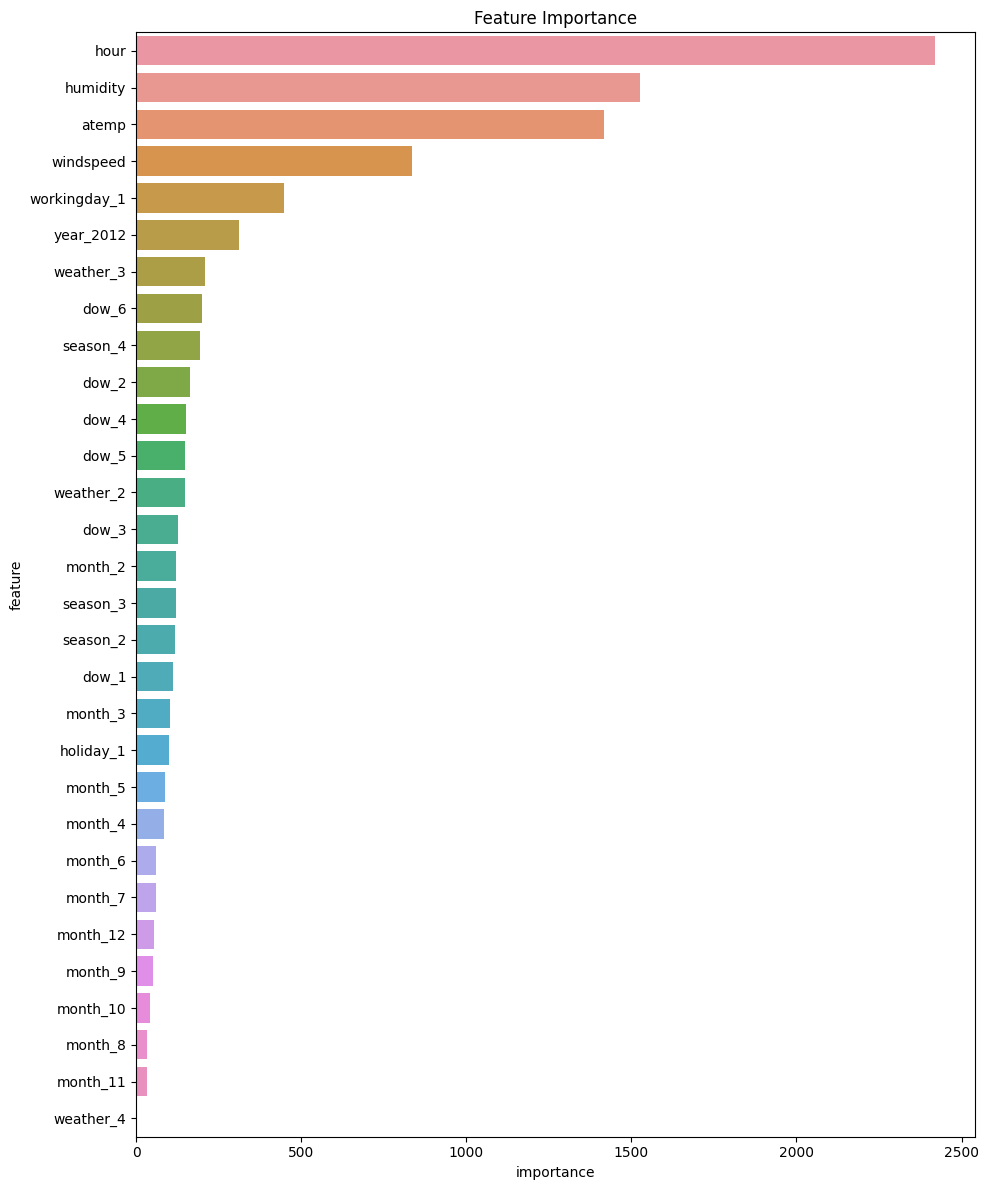

<Figure size 640x480 with 0 Axes>

In [29]:
importances = best_model.feature_importances_

# 시각화용 데이터프레임 생성
feat_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# 시각화
plt.figure(figsize=(10, 12))
sns.barplot(x='importance', y='feature', data=feat_importance_df)
plt.title('Feature Importance')
plt.tight_layout()
plt.show()
plt.savefig('Feature Importance.png', dpi=300)

# Submission

## Test Data Preprocess

In [30]:
test = bike_test

# train과 같은 전처리를 진행해보자
test['datetime'] = test.datetime.apply(pd.to_datetime)

# datetime 타입에서 년, 월, 일, 시간 추출
test['year'] = test.datetime.apply(lambda x : x.year)
test['month'] = test.datetime.apply(lambda x : x.month)
test['day'] = test.datetime.apply(lambda x : x.day)
test['hour'] = test.datetime.apply(lambda x: x.hour)
test['dow'] = test.datetime.apply(lambda x: x.dayofweek)
test.head(3)

# 이미 테스트 데이터셋에는 casual, registered 가 빠져있음
drop_columns = ['datetime','day','temp']
test.drop(drop_columns, axis=1,inplace=True)

# 'year', month', 'day', hour'등의 피처들을 One Hot Encoding
test_ohe = pd.get_dummies(test, 
                          columns=['year', 'month', 'dow','holiday','workingday','season','weather'],
                          drop_first=True
                         )

* test.day.nunique() != train.day.nunique()

## Prediction by the final model

In [31]:
## sample_data를 받아오기
sample = pd.read_csv('/kaggle/input/bike-sharing-demand/sampleSubmission.csv')

# 테스트 데이터셋을 예측
pred = best_model.predict(test_ohe)
# 학습시 로그변환한 target을 썻으니 결과값을 다시 복원해야합니다
pred_exp = np.expm1(pred)

# sample 파일에 예측 값을 넣어주고
sample["count"] = pred_exp

# csv로 저장하기
sample.to_csv("/kaggle/working/submission.csv", index=False)